In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

from models import *
from targets import *
from utils import *

In [19]:
prior = torch.distributions.MultivariateNormal(torch.ones(1), 25*torch.eye(1))

N_D = 10000
multiplicity = 10
target = DeformedCircles()
D_theta = prior.sample([N_D])
D_x = target.sample(D_theta.repeat_interleave(multiplicity, dim=0)).reshape(N_D, 2*multiplicity)

In [20]:
dif = ConditionalDIF(D_x, D_theta, 10,[64,64])
dif.train(200,1000, lr = 5e-3)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:41<00:00,  1.24it/s, loss = 2.682626 ; device: cpu]


In [21]:
N_Obs = 500
theta_Obs= prior.sample([N_Obs])
N_per_obs = 1
x0_Obs=[]
for theta in theta_Obs: 
    x0_Obs.append(target.sample(theta.unsqueeze(0).repeat(N_per_obs,1).repeat_interleave(multiplicity, dim=0)).reshape(N_per_obs, 2*multiplicity) + 3*torch.randn(N_per_obs, 2*multiplicity))
x0_Obs = torch.stack(x0_Obs)

In [22]:
print(x0_Obs.shape)

torch.Size([500, 1, 20])


In [23]:
x0_test = x0_Obs[0].reshape(multiplicity, 2)
print(x0_test.shape)
print(theta_Obs[0])

torch.Size([10, 2])
tensor([0.3270])


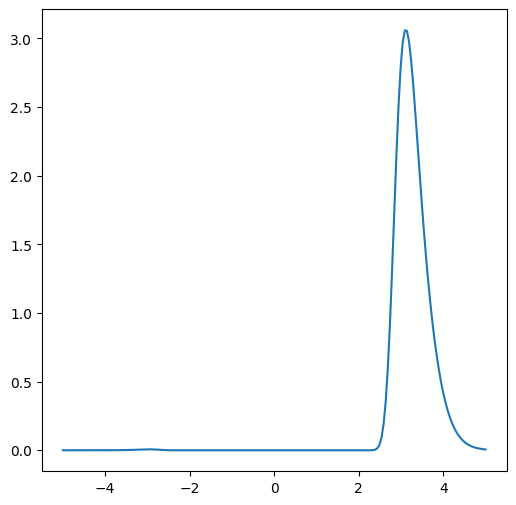

In [24]:
true_posterior_log_prob = lambda theta: prior.log_prob(theta) + torch.sum(target.log_prob(x0_test.unsqueeze(0).repeat(theta.shape[0],1,1), theta.unsqueeze(1).repeat(1, x0_test.shape[0],1)), dim = 1)
plt.figure(figsize = (6,6))
plot_1d_unormalized_function(lambda theta : torch.exp(true_posterior_log_prob(theta.unsqueeze(-1))).detach(), range = [-5,5], bins = 500)
plt.show()

In [25]:
posterior_log_prob = lambda theta: prior.log_prob(theta) + torch.sum(dif.log_prob(x0_Obs[0].unsqueeze(0).repeat(theta.shape[0],1,1), theta.unsqueeze(1).repeat(1, x0_Obs[0].shape[0],1)), dim = 1)

from samplers import IMH
sampler = IMH(posterior_log_prob,1, torch.distributions.MultivariateNormal(torch.zeros(1), torch.eye(1)),200)
samples = sampler.sample(500)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 100.54it/s, acceptance = tensor(0.0150)]


(array([ 1.,  0.,  1.,  1.,  4.,  4.,  6.,  5.,  5.,  8.,  5.,  7.,  8.,
         7.,  2., 13.,  7., 11., 10., 10., 10.,  9.,  3.,  8.,  4.,  7.,
         8.,  6.,  7.,  3.,  3.,  4.,  3.,  0.,  2.,  0.,  2.,  0.,  2.,
         0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.]),
 array([2.04626107, 2.08761382, 2.12896657, 2.17031956, 2.21167231,
        2.25302505, 2.2943778 , 2.33573079, 2.37708354, 2.41843629,
        2.45978904, 2.50114179, 2.54249477, 2.58384752, 2.62520027,
        2.66655302, 2.70790601, 2.74925876, 2.79061151, 2.83196425,
        2.873317  , 2.91466999, 2.95602274, 2.99737549, 3.03872824,
        3.08008099, 3.12143397, 3.16278672, 3.20413947, 3.24549222,
        3.28684521, 3.32819796, 3.3695507 , 3.41090345, 3.4522562 ,
        3.49360919, 3.53496194, 3.57631469, 3.61766744, 3.65902042,
        3.70037317, 3.74172592, 3.78307867, 3.82443142, 3.86578441,
        3.90713716, 3.9484899 , 3.98984265, 4.03119564, 4.07254839,
        4.11390114]),
 <BarContainer

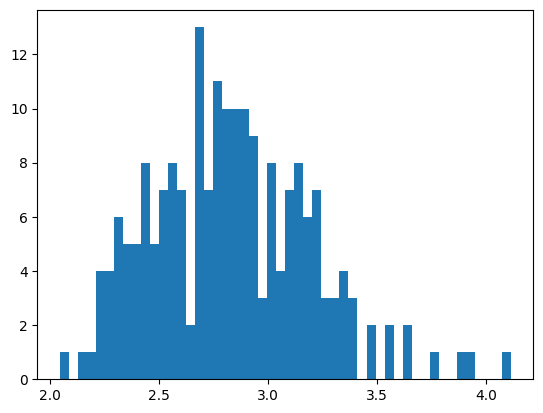

In [26]:
plt.hist(samples.numpy(), bins= 50)